In [3]:
import os

# 현재 디렉터리 확인
print(os.getcwd())


/Users/2gyeong/three_leaf_clover


In [7]:
import pandas as pd

# 데이터 로드
onlinesales = pd.read_csv("data/Onlinesales_info.csv")
customer_info = pd.read_csv("data/Customer_info.csv")

# 날짜 변환
onlinesales['거래날짜'] = pd.to_datetime(onlinesales['거래날짜'])


In [11]:
# 데이터 전처리

# 총 구매 금액 계산
onlinesales['총 구매 금액'] = onlinesales['수량'] * onlinesales['평균금액']

# 결측값 처리
onlinesales.dropna(inplace=True)

# 중복값 확인 및 제거
onlinesales.drop_duplicates(inplace=True)

In [10]:
# 고객별 집계 데이터 생성

# 최신 날짜 기준으로 Recency 계산
latest_date = onlinesales['거래날짜'].max()

# 고객별 RFM 지표 계산
rfm_data = onlinesales.groupby('고객ID').agg({
    '거래날짜': lambda x: (latest_date - x.max()).days,  # Recency
    '거래ID': 'count',  # Frequency
    '총 구매 금액': 'sum'  # Monetary
}).reset_index()

rfm_data.rename(columns={'거래날짜': 'Recency', '거래ID': 'Frequency', '총 구매 금액': 'Monetary'}, inplace=True)



In [13]:
# RFM 점수화
# 점수화
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# RFM 점수 합산
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(int) + rfm_data['F_Score'].astype(int) + rfm_data['M_Score'].astype(int)


In [14]:
# 세그먼트 정의

def segment_customer(row):
    if row['RFM_Score'] >= 13:
        return 'VIP'
    elif row['RFM_Score'] >= 9:
        return 'Loyal'
    elif row['Recency'] > 60:
        return 'At Risk'
    else:
        return 'New'

rfm_data['Segment'] = rfm_data.apply(segment_customer, axis=1)


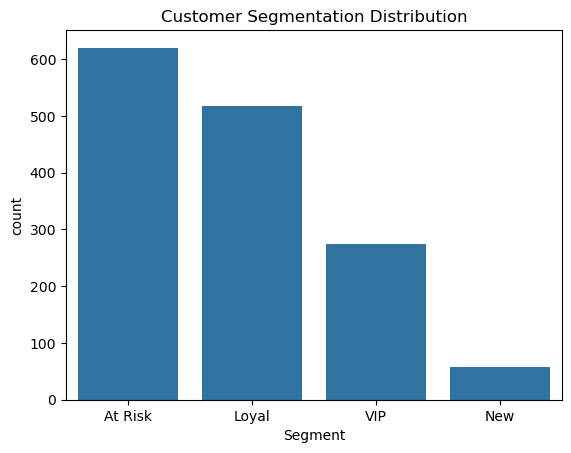

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 세그먼트 분포 시각화
sns.countplot(data=rfm_data, x='Segment', order=rfm_data['Segment'].value_counts().index)
plt.title("Customer Segmentation Distribution")
plt.show()


In [17]:
# 세그먼트별 매출 분석

segment_analysis = rfm_data.groupby('Segment').agg({
    'Monetary': ['mean', 'sum'],
    'Frequency': 'mean'
}).reset_index()
print(segment_analysis)


   Segment     Monetary              Frequency
                   mean         sum       mean
0  At Risk   783.118500   485533.47  10.887097
1    Loyal  3230.354681  1670093.37  38.177950
2      New   511.142281    29135.11   5.789474
3      VIP  9073.111934  2486032.67  95.277372
